In [152]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
torch.manual_seed(0)

In [153]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [154]:
dir_list = os.listdir('free-spoken-digit-dataset-master/recordings/')
print(f'Recordings : {dir_list[0:5]}')

Recordings : ['9_jackson_30.wav', '5_nicolas_41.wav', '7_george_15.wav', '7_jackson_8.wav', '4_jackson_26.wav']


In [155]:
path = []
labels = []
for i in dir_list:
    path.append('free-spoken-digit-dataset-master/recordings/'+str(i))
    labels.append(i.split('_')[0])
data = pd.DataFrame({'path':path,'label':labels})
data.to_csv('data_path.csv')

In [156]:
data.head()

,path,label
0,free-spoken-digit-dataset-master/recordings/9_...,9
1,free-spoken-digit-dataset-master/recordings/5_...,5
2,free-spoken-digit-dataset-master/recordings/7_...,7
3,free-spoken-digit-dataset-master/recordings/7_...,7
4,free-spoken-digit-dataset-master/recordings/4_...,4


In [157]:
df_X = pd.DataFrame(columns=['tensor','sr'])

tensors = []
srs = []
for i in data['path']:
    data_waveform, rate_of_sample = torchaudio.load(i)
    tensors.append(data_waveform)
    srs.append(rate_of_sample)
df_X['tensor'] = tensors
df_X['sr'] = srs
df_X = pd.concat([data,df_X],axis=1)
df_X=df_X.fillna(0)

In [158]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1, target_variable=None):

    """ This function partition the data in a stratified manner.
    Arguments
    ---------
    df : pd.DataFrame
        The dataframe that we want to partition.
    train_split: float
        The training data partition of the entier data (should be in [0,1]).
    val_split: float
        The validation data partition of the entier data (should be in [0,1]).
    test_split: float
        The testing data partition of the entier data (should be in [0,1]).
    target_variable: str
        The name of the target column.
        
    Returns
    --------
    train_ds: np.array
        The training dataset as a numpy array.
    val_ds: np.array
        The validation dataset as a numpy array.
    test_ds: np.array
        The testing dataset as a numpy array.
    """
    #Test statements
    assert val_split == test_split, "val_split and test_split must be equal."
    assert (train_split + test_split + val_split) == 1, "the sum of train_split, test_split and val split must be equal to 1."
    
    df_sample = df.sample(frac=1, random_state=42)

    if target_variable is not None:
        grouped_df = df_sample.groupby(target_variable)
        arr_list = [np.split(g, [int(train_split * len(g)), int((1 - val_split) * len(g))]) for i, g in grouped_df]

        train_ds = pd.concat([t[0] for t in arr_list])
        val_ds = pd.concat([t[1] for t in arr_list])
        test_ds = pd.concat([v[2] for v in arr_list])

    else:
        indices_or_sections = [int(train_split * len(df)), int((1 - val_split) * len(df))]
        train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [159]:
train_ds, test_ds, val_ds  = get_dataset_partitions_pd(df_X.drop(['path'],axis=1),train_split=0.8, val_split=0.1, test_split=0.1, target_variable='label')

In [160]:
print(f'train_ds.shape: {train_ds.shape}\n\n'+
      f'val_ds.shape: {val_ds.shape}\n\n'+
      f'test_ds.shape: {test_ds.shape}\n\n')

train_ds.shape: (2400, 3)

val_ds.shape: (300, 3)

test_ds.shape: (300, 3)




In [161]:
print(f'Distribution in training set: \n{train_ds.label.value_counts().sort_index() / len(train_ds)}\n\n'+
      f'Distribution in validation set: \n{val_ds.label.value_counts().sort_index() / len(val_ds)}\n\n'+
    f'Distribution in testing set: \n{test_ds.label.value_counts().sort_index() / len(test_ds)}')

Distribution in training set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in validation set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in testing set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64


In [162]:
train_set = train_ds[['tensor', 'sr', 'label']].to_numpy()
validation_set = val_ds[['tensor', 'sr', 'label']].to_numpy()
test_set = test_ds[['tensor', 'sr', 'label']].to_numpy()

In [163]:
waveform0, sample_rate0, numclass0 = train_set[0]
waveform1, sample_rate1, numclass1 = validation_set[0]
waveform2, sample_rate2, numclass2 = test_set[0]

In [164]:
waveform2

tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])

In [165]:
print('Sample of training set')
waveform0, sample_rate0, numclass0

Sample of training set


(tensor([[ 0.0005,  0.0002,  0.0003,  ..., -0.0005, -0.0002,  0.0001]]),
 8000,
 '0')

In [166]:
waveform0.shape

torch.Size([1, 4455])

In [167]:
print('Sample first entry of validation set')
waveform1, sample_rate1, numclass1

Sample first entry of validation set


(tensor([[-0.0101, -0.0121, -0.0153,  ..., -0.0081, -0.0084, -0.0098]]),
 8000,
 '0')

In [168]:
print('Sample first entry of test set')
waveform2, sample_rate2, numclass2

Sample first entry of test set


(tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]]),
 8000,
 '0')

In [169]:
print('Sample 500th entry of all sets\n')
train_set[200], validation_set[200], test_set[200]

Sample 500th entry of all sets



(array([tensor([[ 0.0000,  0.0003,  0.0001,  ..., -0.0005, -0.0005, -0.0002]]),
        8000, '0'], dtype=object),
 array([tensor([[ 0.0033, -0.0040,  0.0033,  ...,  0.0073,  0.0050,  0.0017]]),
        8000, '6'], dtype=object),
 array([tensor([[ 0.0000,  0.0000, -0.0156,  ..., -0.0078,  0.0000, -0.0078]]),
        8000, '6'], dtype=object))

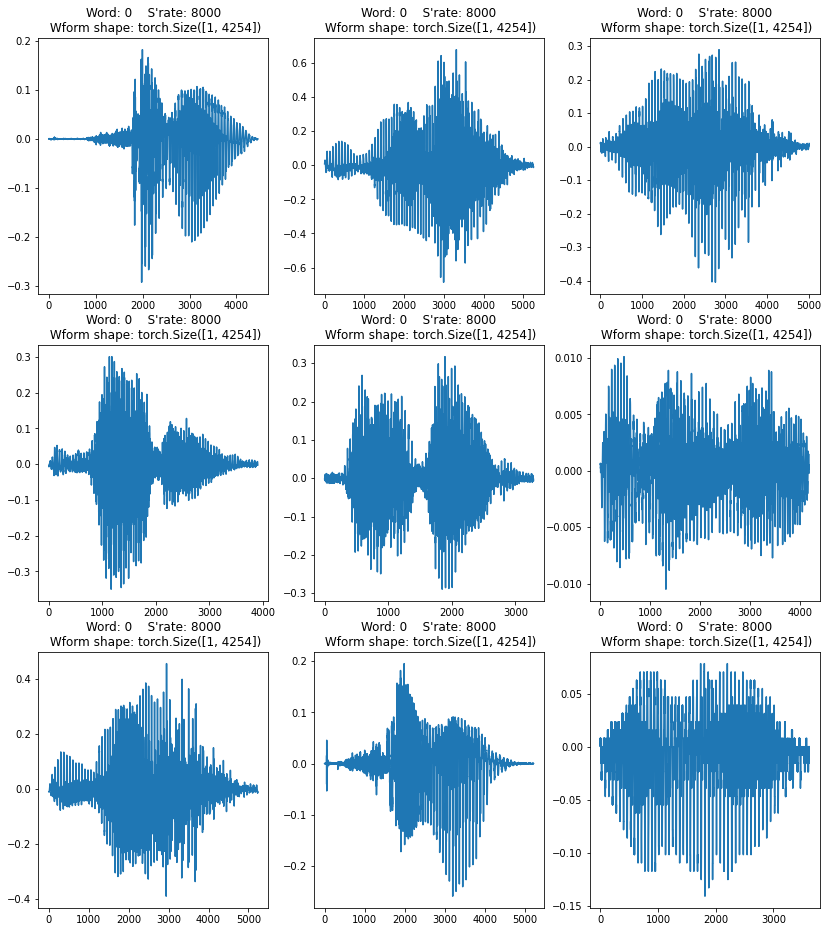

In [170]:
# Some of the training set segments (waveforms)
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 16))
for i in range (9):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(train_set[i][0].t().numpy())
    ax.set_title(f"Word: {test_set[i][2]}    S'rate: {test_set[i][1]}" + f'\n Wform shape: {waveform2.size()}')

plt.show()

In [171]:
numclasses = sorted(list(set(element[2] for element in train_set)))
numclasses

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [172]:
print('Total number of entries in training set :', (len(train_set)))
print('Total number of entries in validation set :', (len(validation_set)))
print('Total number of entries in test set :', (len(test_set)))

Total number of entries in training set : 2400
Total number of entries in validation set : 300
Total number of entries in test set : 300


In [173]:
#  number of segments per digit class in train set
print('Total number of entries in training set :', (len(train_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(train_set)):
        if (train_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in training set : 2400
Number of num class entries : 10

Num class : Count
0  : 240
1  : 240
2  : 240
3  : 240
4  : 240
5  : 240
6  : 240
7  : 240
8  : 240
9  : 240


In [174]:
#  number of segments per digit class in validation set
print('Total number of entries in validation set :', (len(validation_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(validation_set)):
        if (validation_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in validation set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [175]:
#  number of segments per digit class in test set
print('Total number of entries in test set :', (len(test_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(test_set)):
        if (test_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in test set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [176]:
waveform_test, *_ = test_set[0]
print(test_set[0])
ipd.Audio(waveform_test.numpy(), rate=sample_rate2)

[tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])
 8000 '0']


In [177]:
new_sr = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate2, new_freq=new_sr)
transformed = transform(waveform_test)

ipd.Audio(transformed.numpy(), rate=new_sr)

In [178]:
def index_to_numclass(index):
    
    """
    This function return digit based on index in numclasses.
    
    Arguments
    ----------
    index: int
        index of the digit in the numclasses.

    Returns
    --------
    _ : str
        the numclass according to the index.
    """
    return numclasses[index]

def numclass_to_index(num):
    """
    This function return the index of the digit in the numclasses.
    
    Arguments
    ----------
    word: str
        the numclass we want to know its index in numclasses.

    Returns
    --------
    _ : int
        the index of the numclass in numclasses.
    """
    return torch.tensor(numclasses.index(num))

In [179]:
def pad_sequence(batch):
    """
    this function makes all tensor in a batch the same length by padding with zeros.
    
    Arguments
    ----------
    batch: torch.tensor
        a batch of audio segments.
    
    Returns
    -------
    _ : torch.tensor
        a batch of audio segments with the same length after padding with zero.
    """
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [180]:
def collate_fn(batch):
    """
    This function gather in lists, and encode numclasses as indices, group the list of tensors into a 
    batched tensor and stack - concatenates a sequence of tensors along a new dimension.
    
    Arguments
    ----------
    batch: torch.tensor
        a tensor contains a batch size enteries.
    
    Returns
    -------
    tensors: torch.tensor
        the data that represents the speech segments data with the same lenght after padding.
    targets: torch.tensor
        that contains the "list" of target values of each entry in the batch.
    """
    tensors, targets = [], []
    for waveform, _, numclass, *_ in batch:
        tensors += [waveform]
        targets += [numclass_to_index(numclass)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [181]:
batch_size = 32

In [182]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [183]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
        drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [184]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## CNN3GRU definition

In [185]:
class CNN3GRU(nn.Module):
    """
    This is the implementation of the CNN3GRU model where 3 is the number of convolutional layers and the GRU
    layers in the model.
    """
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=3):
        super().__init__()
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining the layers
        # CNN layers
        self.conv1 = nn.Conv1d(n_input, 2*n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(2*n_channel)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=6, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(4)
        
        # Fully connected layer
        self.fc1 = nn.Linear(2*n_channel, n_channel)
        self.relu3 = nn.LeakyReLU()
        
        # GRU layer
        self.gru1 = nn.GRU(n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        
        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu4 = nn.LeakyReLU()
       

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu3(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu4(x[:,-1]))
        
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        """
        This method generates the first hidden state of zeros which we'll use in the forward pass
        We'll send the tensor holding the hidden state to the device we specified earlier as well.
        """
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('CNN3GRU model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))
print('transformed :', transformed[0])

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_CNN3GRU = CNN3GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_CNN3GRU.to(device)
print(model_CNN3GRU)

n = count_parameters(model_CNN3GRU)
print("Number of parameters: %s" % n)

CNN3GRU model
Model n_input 1
Model n_output 10
transformed : tensor([-0.0004, -0.0007, -0.0008,  ..., -0.0004, -0.0005, -0.0003])
CNN3GRU(
  (conv1): Conv1d(1, 6, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 6, kernel_size=(6,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6, out_features=3, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (gru1): GRU(3, 32, num_layers=2, batch_first=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (relu4): LeakyReLU(negative_slope=0.01)
)
Number of parameters: 11451


## CNN5GRU definition

In [186]:
class CNN5GRU(nn.Module):
    """
    This is the implementation of the CNN5GRU model where 5 is the number of convolutional layers and the GRU
    layers in the model.
    """
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=5):
        super().__init__()
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining the layers
        # CNN layers
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)
        
        # Fully connected layer
        self.fc1 = nn.Linear(4 * n_channel, 2*n_channel)
        self.relu5 = nn.LeakyReLU()
        
        # GRU layer
        self.gru1 = nn.GRU(2*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        
        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu6 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        x = self.pool4(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu5(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu6(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h

    
    def init_hidden(self, batch_size):
        """
        This method generates the first hidden state of zeros which we'll use in the forward pass
        We'll send the tensor holding the hidden state to the device we specified earlier as well.
        """
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
print('CNN5GRU model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_CNN5GRU = CNN5GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_CNN5GRU.to(device)
print(model_CNN5GRU)

n = count_parameters(model_CNN5GRU)
print("Number of parameters: %s" % n)

CNN5GRU model
Model n_input 1
Model n_output 10
CNN5GRU(
  (conv1): Conv1d(1, 5, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(20, ep

## CNN11GRU definition

In [187]:
class CNN11GRU(nn.Module):
    """
    This is the implementation of the CNN11GRU model where 11 is the number of convolutional layers and the GRU
    layers in the model.
    """
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=11):
        super().__init__()
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining the layers
        # CNN layers
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
 
        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)
        self.relu10 = nn.LeakyReLU()
        
        # Fully connected layer
        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        # GRU layer
        self.gru1 = nn.GRU(4*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        
        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu12 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn1(x))
        
        x = self.pool2(x)

        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool3(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.pool4(x)

        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.conv10(x)
        x = self.relu10(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu11(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu12(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        """
        This method generates the first hidden state of zeros which we'll use in the forward pass
        We'll send the tensor holding the hidden state to the device we specified earlier as well.
        """
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('CNN11GRU model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_CNN11GRU = CNN11GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_CNN11GRU.to(device)
print(model_CNN11GRU)

n = count_parameters(model_CNN11GRU)
print("Number of parameters: %s" % n)

CNN11GRU model
Model n_input 1
Model n_output 10
CNN11GRU(
  (conv1): Conv1d(1, 11, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(11, 22, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): Leaky

## CNN18GRU definition

In [188]:
class CNN18GRU(nn.Module):
    """
    This is the implementation of the CNN18GRU model where 18 is the number of convolutional layers and the GRU
    layers in the model.
    """
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=18):
        super().__init__()
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining the layers
        # CNN layers
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4, stride=None)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4, stride=None)

        self.conv6 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(2 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(2 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(2 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.conv9 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(2 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4, stride=None)
 
        self.conv10 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(4 * n_channel)
        self.relu10 = nn.LeakyReLU()
        
        self.conv11 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm1d(4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        self.conv12 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm1d(4 * n_channel)
        self.relu12 = nn.LeakyReLU()
        
        self.conv13 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm1d(4 * n_channel)
        self.relu13 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4, stride=None)

        self.conv14 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn14 = nn.BatchNorm1d(8 * n_channel)
        self.relu14 = nn.LeakyReLU()
        
        self.conv15 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn15 = nn.BatchNorm1d(8 * n_channel)
        self.relu15 = nn.LeakyReLU()
        
        self.conv16 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn16 = nn.BatchNorm1d(8 * n_channel)
        self.relu16 = nn.LeakyReLU()
        
        self.conv17 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn17 = nn.BatchNorm1d(8 * n_channel)
        self.relu17 = nn.LeakyReLU()
        
        # Fully connected layer
        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu18 = nn.LeakyReLU()
        
        # GRU layer
        self.gru1 = nn.GRU(4 * n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        
        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu19 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool2(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.pool3(x)

        x = self.conv10(x)
        x = self.relu10(self.bn10(x))
        
        x = self.conv11(x)
        x = self.relu11(self.bn11(x))
        
        x = self.conv12(x)
        x = self.relu12(self.bn12(x))
        
        x = self.conv13(x)
        x = self.relu13(self.bn13(x))
        
        x = self.pool4(x)

        x = self.conv14(x)
        x = self.relu14(self.bn14(x))
        
        x = self.conv15(x)
        x = self.relu15(self.bn15(x))
        
        x = self.conv16(x)
        x = self.relu16(self.bn16(x))
        
        x = self.conv17(x)
        x = self.relu17(self.bn17(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu18(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu19(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        """
        This method generates the first hidden state of zeros which we'll use in the forward pass
        We'll send the tensor holding the hidden state to the device we specified earlier as well.
        """
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('CNN18GRU model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_CNN18GRU = CNN18GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)

model_CNN18GRU.to(device)
print(model_CNN18GRU)

n = count_parameters(model_CNN18GRU)
print("Number of parameters: %s" % n)

CNN18GRU model
Model n_input 1
Model n_output 10
CNN18GRU(
  (conv1): Conv1d(1, 18, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv1d(18, 18, kernel_size=(3,), stride=(1,), pad

In [189]:
def train(model, epoch, log_interval, n_layers):
    """
    This function is the training loop of the model for each epoch.
    
    Arguments
    ----------
    model: nn.Model
        The model that we'll train.
    epoch: int
        The epoch we're in.
    log_interval: int
        After how many epoch we should log the results.
    n_layers: int
        The number of layers for the CNN and the GRU components of the model.
    """
    model.train()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        # apply transform and model on whole batch directly on device
        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)
        
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch_index % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_index * len(data)}/{len(train_loader.dataset)} ({100. * batch_index / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(train_loader.dataset)} ({100. * right / len(train_loader.dataset):.0f}%)")
            
        pbar.update(pbar_update)
        
        losses_train.append(loss.item())

    acc = 100. * (right/len(train_loader.dataset))
    accuracy_train.append(acc)

In [190]:
def nr_of_right(pred, target):
    """
    This function counts the number of right predictions
    """
    return pred.squeeze().eq(target).sum().item()

In [191]:
def get_probable_idx(tensor):
    """
    this function finds the most probable numclass index for each element in the batch.
    """
    return tensor.argmax(dim=-1)

In [192]:
def validate(model, epoch, n_layers):
    """
    This function is the validation loop of the model for each epoch.
    
    Arguments
    ----------
    model: nn.Model
        The model that we'll validate.
    epoch: int
        The epoch we're in.
    n_layers: int
        The number of layers for the CNN and the GRU components of the model.
    """
    
    model.eval()
    right = 0

    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for data, target in validation_loader:

        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        pbar.update(pbar_update)

    print(f"\nValidation Epoch: {epoch} \tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(validation_loader.dataset)} ({100. * right / len(validation_loader.dataset):.0f}%)\n")
     
    acc = 100. * right / len(validation_loader.dataset)
    accuracy_validation.append(acc)
    losses_validation.append(loss.item())

In [193]:
def test(model, n_layers):
    
    """
    This function is the testing loop of the model on the test set.
    
    Arguments
    ----------
    model: nn.Model
        The model that we'll train.
    n_layers: int
        The number of layers for the CNN and the GRU components of the model.
    """
    
    model.eval()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    y_true = []
    y_pred = []
    
    for data, target in test_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        targets = target.data.cpu().numpy()
        y_true.extend(targets)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)
        
        
        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 

    print(f"\nTest set accuracy: {right}/{len(test_loader.dataset)} ({100. * right / len(test_loader.dataset):.0f}%)\n")

    return (100. * right / len(test_loader.dataset)), y_pred, y_true

In [194]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=True):
    
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    fig = plt.figure(figsize=figsize)
    if normalize:
        confusion_matrix_1 = (confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        confusion_matrix_1 = confusion_matrix
        print('Confusion matrix, without normalization')
    df_cm = pd.DataFrame(
        confusion_matrix_1, index=class_names, columns=class_names
    )
    
    labels = (np.asarray(["{:1.2f} % \n ({})".format(value, value_1) for value, value_1 in zip(confusion_matrix_1.flatten(),confusion_matrix.flatten())])).reshape(confusion_matrix.shape)
    try:
        heatmap = sn.heatmap(df_cm, annot=labels, fmt='' if normalize else 'd')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## CNN3GRU Train

In [195]:
epoch_count = 100

In [196]:
#CNN3GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_CNN3GRU.parameters(), lr=0.01, weight_decay=0.00006)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)


transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        print("Train")
        train(model_CNN3GRU, epoch, log_interval, n_layers=3)
        print("Validate")
        validate(model_CNN3GRU, epoch, n_layers=3)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train
Train Epoch: 1 [0/2400 (0%)]	Loss: 2.319976	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.304313	Accuracy: 82/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.027988	Accuracy: 179/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 1.921851	Accuracy: 316/2400 (13%)
Validate

Validation Epoch: 1 	Loss: 1.925821	Accuracy: 47/300 (16%)

Train
Train Epoch: 2 [0/2400 (0%)]	Loss: 2.026632	Accuracy: 9/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 1.969755	Accuracy: 129/2400 (5%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.948805	Accuracy: 272/2400 (11%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.797453	Accuracy: 394/2400 (16%)
Validate

Validation Epoch: 2 	Loss: 1.868685	Accuracy: 63/300 (21%)

Train
Train Epoch: 3 [0/2400 (0%)]	Loss: 2.092411	Accuracy: 7/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.703175	Accuracy: 156/2400 (6%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.756020	Accuracy: 289/2400 (12%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.884956	Accuracy: 440/2400 (

Train Epoch: 23 [1920/2400 (80%)]	Loss: 1.903848	Accuracy: 860/2400 (36%)
Validate

Validation Epoch: 23 	Loss: 1.524830	Accuracy: 133/300 (44%)

Train
Train Epoch: 24 [0/2400 (0%)]	Loss: 1.538076	Accuracy: 12/2400 (0%)
Train Epoch: 24 [640/2400 (27%)]	Loss: 1.385627	Accuracy: 280/2400 (12%)
Train Epoch: 24 [1280/2400 (53%)]	Loss: 1.402920	Accuracy: 548/2400 (23%)
Train Epoch: 24 [1920/2400 (80%)]	Loss: 1.311193	Accuracy: 839/2400 (35%)
Validate

Validation Epoch: 24 	Loss: 1.619794	Accuracy: 154/300 (51%)

Train
Train Epoch: 25 [0/2400 (0%)]	Loss: 1.182893	Accuracy: 13/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.496893	Accuracy: 279/2400 (12%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.391650	Accuracy: 547/2400 (23%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.430382	Accuracy: 814/2400 (34%)
Validate

Validation Epoch: 25 	Loss: 1.633439	Accuracy: 148/300 (49%)

Train
Train Epoch: 26 [0/2400 (0%)]	Loss: 0.999146	Accuracy: 24/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.30501

Train Epoch: 46 [1280/2400 (53%)]	Loss: 1.060069	Accuracy: 844/2400 (35%)
Train Epoch: 46 [1920/2400 (80%)]	Loss: 0.956547	Accuracy: 1236/2400 (52%)
Validate

Validation Epoch: 46 	Loss: 0.898476	Accuracy: 204/300 (68%)

Train
Train Epoch: 47 [0/2400 (0%)]	Loss: 0.873964	Accuracy: 19/2400 (1%)
Train Epoch: 47 [640/2400 (27%)]	Loss: 0.936072	Accuracy: 439/2400 (18%)
Train Epoch: 47 [1280/2400 (53%)]	Loss: 0.757013	Accuracy: 872/2400 (36%)
Train Epoch: 47 [1920/2400 (80%)]	Loss: 0.828728	Accuracy: 1265/2400 (53%)
Validate

Validation Epoch: 47 	Loss: 0.871924	Accuracy: 196/300 (65%)

Train
Train Epoch: 48 [0/2400 (0%)]	Loss: 0.905121	Accuracy: 22/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 0.580550	Accuracy: 442/2400 (18%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 1.037544	Accuracy: 873/2400 (36%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 1.000680	Accuracy: 1277/2400 (53%)
Validate

Validation Epoch: 48 	Loss: 0.979793	Accuracy: 198/300 (66%)

Train
Train Epoch: 49 [0/2400 (0%)]	Loss: 0

Train Epoch: 69 [1280/2400 (53%)]	Loss: 0.961438	Accuracy: 876/2400 (36%)
Train Epoch: 69 [1920/2400 (80%)]	Loss: 0.720939	Accuracy: 1296/2400 (54%)
Validate

Validation Epoch: 69 	Loss: 0.733169	Accuracy: 208/300 (69%)

Train
Train Epoch: 70 [0/2400 (0%)]	Loss: 0.731444	Accuracy: 21/2400 (1%)
Train Epoch: 70 [640/2400 (27%)]	Loss: 0.676114	Accuracy: 458/2400 (19%)
Train Epoch: 70 [1280/2400 (53%)]	Loss: 0.906947	Accuracy: 893/2400 (37%)
Train Epoch: 70 [1920/2400 (80%)]	Loss: 0.806056	Accuracy: 1311/2400 (55%)
Validate

Validation Epoch: 70 	Loss: 0.706655	Accuracy: 207/300 (69%)

Train
Train Epoch: 71 [0/2400 (0%)]	Loss: 0.779497	Accuracy: 24/2400 (1%)
Train Epoch: 71 [640/2400 (27%)]	Loss: 0.882745	Accuracy: 467/2400 (19%)
Train Epoch: 71 [1280/2400 (53%)]	Loss: 0.979529	Accuracy: 882/2400 (37%)
Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.886641	Accuracy: 1329/2400 (55%)
Validate

Validation Epoch: 71 	Loss: 0.722271	Accuracy: 208/300 (69%)

Train
Train Epoch: 72 [0/2400 (0%)]	Loss: 0

Train Epoch: 92 [640/2400 (27%)]	Loss: 1.025743	Accuracy: 447/2400 (19%)
Train Epoch: 92 [1280/2400 (53%)]	Loss: 0.652830	Accuracy: 876/2400 (36%)
Train Epoch: 92 [1920/2400 (80%)]	Loss: 1.038074	Accuracy: 1301/2400 (54%)
Validate

Validation Epoch: 92 	Loss: 0.691467	Accuracy: 211/300 (70%)

Train
Train Epoch: 93 [0/2400 (0%)]	Loss: 1.159947	Accuracy: 16/2400 (1%)
Train Epoch: 93 [640/2400 (27%)]	Loss: 0.839059	Accuracy: 454/2400 (19%)
Train Epoch: 93 [1280/2400 (53%)]	Loss: 0.651056	Accuracy: 911/2400 (38%)
Train Epoch: 93 [1920/2400 (80%)]	Loss: 0.964423	Accuracy: 1363/2400 (57%)
Validate

Validation Epoch: 93 	Loss: 0.729385	Accuracy: 208/300 (69%)

Train
Train Epoch: 94 [0/2400 (0%)]	Loss: 0.728428	Accuracy: 23/2400 (1%)
Train Epoch: 94 [640/2400 (27%)]	Loss: 0.753481	Accuracy: 472/2400 (20%)
Train Epoch: 94 [1280/2400 (53%)]	Loss: 0.819780	Accuracy: 908/2400 (38%)
Train Epoch: 94 [1920/2400 (80%)]	Loss: 0.928822	Accuracy: 1338/2400 (56%)
Validate

Validation Epoch: 94 	Loss: 0.67

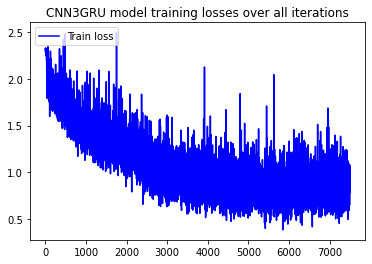

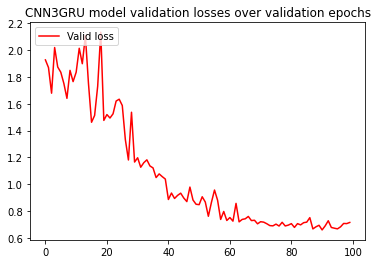

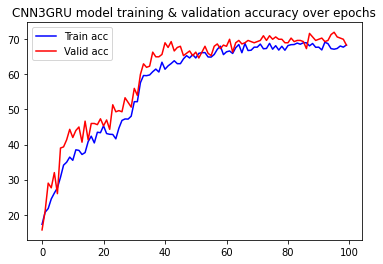

In [197]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("CNN3GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("CNN3GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("CNN3GRU model training & validation accuracy over epochs")
plt.show()

In [198]:
CNN3GRU_test_acc_result, y_pred, y_true = test(model_CNN3GRU, n_layers=3)
print(CNN3GRU_test_acc_result)


Test set accuracy: 179/300 (60%)

59.666666666666664


Normalized confusion matrix


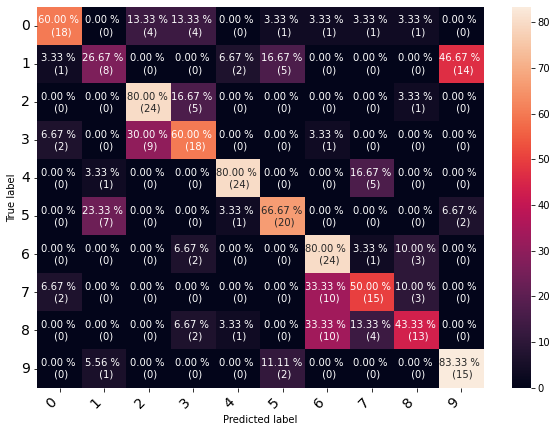

In [199]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## CNN5GRU Train

In [200]:
#CNN5GRU train & validate
log_interval = 20


pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_CNN5GRU.parameters(), lr=0.01, weight_decay=0.00003)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_CNN5GRU, epoch, log_interval, n_layers=5)
        validate(model_CNN5GRU, epoch, n_layers=5)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.304758	Accuracy: 2/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.260851	Accuracy: 78/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 1.941255	Accuracy: 184/2400 (8%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 1.717747	Accuracy: 319/2400 (13%)

Validation Epoch: 1 	Loss: 2.024034	Accuracy: 56/300 (19%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 1.871729	Accuracy: 7/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 1.665550	Accuracy: 149/2400 (6%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.832839	Accuracy: 318/2400 (13%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.775334	Accuracy: 486/2400 (20%)

Validation Epoch: 2 	Loss: 1.776887	Accuracy: 80/300 (27%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 1.836831	Accuracy: 6/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.782991	Accuracy: 190/2400 (8%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.997775	Accuracy: 371/2400 (15%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.678590	Accuracy: 561/2400 (23%)

Validation Epoch: 3 	Loss: 1.7


Validation Epoch: 24 	Loss: 1.103684	Accuracy: 139/300 (46%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 1.237830	Accuracy: 17/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.547477	Accuracy: 317/2400 (13%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 0.959220	Accuracy: 673/2400 (28%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.413140	Accuracy: 1015/2400 (42%)

Validation Epoch: 25 	Loss: 1.278903	Accuracy: 143/300 (48%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 1.100884	Accuracy: 15/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.059515	Accuracy: 371/2400 (15%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 1.270299	Accuracy: 731/2400 (30%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 1.237932	Accuracy: 1075/2400 (45%)

Validation Epoch: 26 	Loss: 1.240180	Accuracy: 94/300 (31%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 1.301301	Accuracy: 12/2400 (0%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 1.672476	Accuracy: 339/2400 (14%)
Train Epoch: 27 [1280/2400 (53%)]	Loss: 1.054273	Accuracy: 709/2400 (30%)
Train Epoch: 27 [

Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.585478	Accuracy: 887/2400 (37%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.863210	Accuracy: 1336/2400 (56%)

Validation Epoch: 48 	Loss: 0.866676	Accuracy: 198/300 (66%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.664189	Accuracy: 23/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.711941	Accuracy: 463/2400 (19%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.647847	Accuracy: 871/2400 (36%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.676397	Accuracy: 1308/2400 (54%)

Validation Epoch: 49 	Loss: 0.925711	Accuracy: 193/300 (64%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.687068	Accuracy: 26/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.752732	Accuracy: 473/2400 (20%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 0.833976	Accuracy: 903/2400 (38%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 0.532753	Accuracy: 1349/2400 (56%)

Validation Epoch: 50 	Loss: 0.828641	Accuracy: 197/300 (66%)

Train Epoch: 51 [0/2400 (0%)]	Loss: 1.130474	Accuracy: 18/2400 (1%)
Train Epoch: 5


Validation Epoch: 71 	Loss: 0.778110	Accuracy: 202/300 (67%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.828096	Accuracy: 23/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.741714	Accuracy: 486/2400 (20%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.877261	Accuracy: 935/2400 (39%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.509791	Accuracy: 1408/2400 (59%)

Validation Epoch: 72 	Loss: 0.769188	Accuracy: 204/300 (68%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.813840	Accuracy: 22/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.557395	Accuracy: 504/2400 (21%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.521774	Accuracy: 948/2400 (40%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 0.624698	Accuracy: 1391/2400 (58%)

Validation Epoch: 73 	Loss: 0.807007	Accuracy: 196/300 (65%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 0.741355	Accuracy: 21/2400 (1%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 0.585455	Accuracy: 477/2400 (20%)
Train Epoch: 74 [1280/2400 (53%)]	Loss: 0.674414	Accuracy: 955/2400 (40%)
Train Epoch: 74 

Train Epoch: 95 [640/2400 (27%)]	Loss: 0.855914	Accuracy: 482/2400 (20%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.813559	Accuracy: 960/2400 (40%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.519676	Accuracy: 1418/2400 (59%)

Validation Epoch: 95 	Loss: 0.743534	Accuracy: 202/300 (67%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.772224	Accuracy: 20/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.613989	Accuracy: 503/2400 (21%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.765267	Accuracy: 955/2400 (40%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.894378	Accuracy: 1409/2400 (59%)

Validation Epoch: 96 	Loss: 0.717076	Accuracy: 205/300 (68%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 0.585028	Accuracy: 26/2400 (1%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 0.625899	Accuracy: 467/2400 (19%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 0.514424	Accuracy: 948/2400 (40%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 0.698363	Accuracy: 1412/2400 (59%)

Validation Epoch: 97 	Loss: 0.756986	Accuracy: 205/300 (68%)

Train Epo

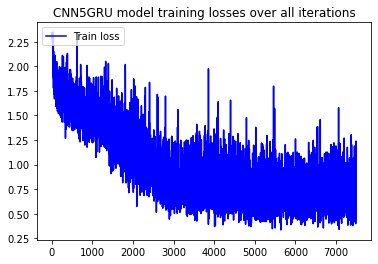

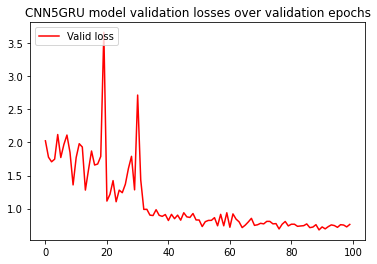

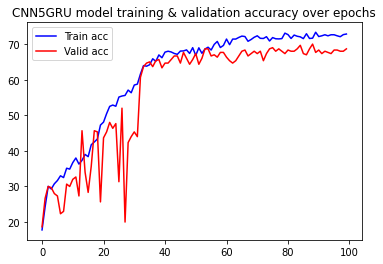

In [201]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("CNN5GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("CNN5GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("CNN5GRU model training & validation accuracy over epochs")
plt.show()

In [202]:
CNN5GRU_test_acc_result, y_pred, y_true = test(model_CNN5GRU, n_layers=5)
print(CNN5GRU_test_acc_result)


Test set accuracy: 194/300 (65%)

64.66666666666667


Normalized confusion matrix


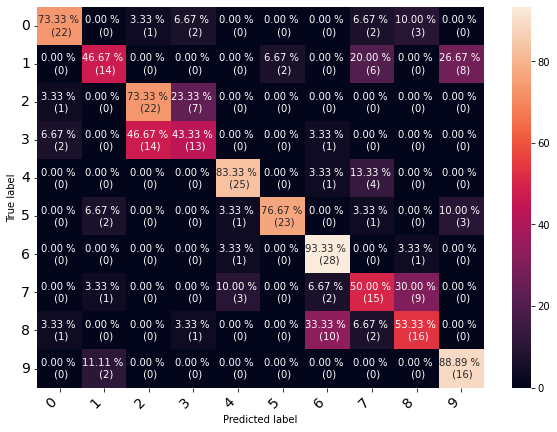

In [203]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## CNN11GRU Train

In [204]:
#CNN11GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_CNN11GRU.parameters(), lr=0.005, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_CNN11GRU, epoch, log_interval, n_layers=11)
        validate(model_CNN11GRU, epoch, n_layers=11)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.311013	Accuracy: 6/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.268194	Accuracy: 81/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.248356	Accuracy: 170/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.100953	Accuracy: 278/2400 (12%)

Validation Epoch: 1 	Loss: 2.199484	Accuracy: 56/300 (19%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 1.984296	Accuracy: 12/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.150406	Accuracy: 152/2400 (6%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.906106	Accuracy: 310/2400 (13%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 2.162591	Accuracy: 463/2400 (19%)

Validation Epoch: 2 	Loss: 2.736436	Accuracy: 48/300 (16%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 1.802056	Accuracy: 6/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.758783	Accuracy: 192/2400 (8%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.829936	Accuracy: 358/2400 (15%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 2.005389	Accuracy: 519/2400 (22%)

Validation Epoch: 3 	Loss: 2.

Train Epoch: 24 [1920/2400 (80%)]	Loss: 1.090019	Accuracy: 872/2400 (36%)

Validation Epoch: 24 	Loss: 1.863648	Accuracy: 111/300 (37%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 1.507181	Accuracy: 14/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.499347	Accuracy: 306/2400 (13%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.338985	Accuracy: 616/2400 (26%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.093819	Accuracy: 902/2400 (38%)

Validation Epoch: 25 	Loss: 1.920338	Accuracy: 93/300 (31%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 1.298101	Accuracy: 15/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.201028	Accuracy: 304/2400 (13%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 1.153670	Accuracy: 602/2400 (25%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 1.270364	Accuracy: 889/2400 (37%)

Validation Epoch: 26 	Loss: 1.389127	Accuracy: 99/300 (33%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 1.322963	Accuracy: 14/2400 (1%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 1.049361	Accuracy: 318/2400 (13%)
Train Epoch: 27 [128

Train Epoch: 48 [640/2400 (27%)]	Loss: 0.961502	Accuracy: 349/2400 (15%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 1.017637	Accuracy: 693/2400 (29%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 1.083849	Accuracy: 1055/2400 (44%)

Validation Epoch: 48 	Loss: 1.548861	Accuracy: 121/300 (40%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.989372	Accuracy: 19/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 1.172699	Accuracy: 377/2400 (16%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.925938	Accuracy: 727/2400 (30%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.962440	Accuracy: 1067/2400 (44%)

Validation Epoch: 49 	Loss: 1.225444	Accuracy: 133/300 (44%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 1.190588	Accuracy: 16/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.989651	Accuracy: 359/2400 (15%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 0.904124	Accuracy: 709/2400 (30%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 1.175318	Accuracy: 1049/2400 (44%)

Validation Epoch: 50 	Loss: 1.397567	Accuracy: 122/300 (41%)

Train Epo

Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.959490	Accuracy: 1199/2400 (50%)

Validation Epoch: 71 	Loss: 1.560137	Accuracy: 120/300 (40%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.915985	Accuracy: 22/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.928666	Accuracy: 405/2400 (17%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.925917	Accuracy: 828/2400 (34%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.888647	Accuracy: 1210/2400 (50%)

Validation Epoch: 72 	Loss: 1.482903	Accuracy: 121/300 (40%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.930702	Accuracy: 22/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.816668	Accuracy: 416/2400 (17%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.848633	Accuracy: 789/2400 (33%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 0.907570	Accuracy: 1172/2400 (49%)

Validation Epoch: 73 	Loss: 1.465690	Accuracy: 123/300 (41%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 1.139063	Accuracy: 12/2400 (0%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 0.968695	Accuracy: 412/2400 (17%)
Train Epoch: 74

Train Epoch: 95 [640/2400 (27%)]	Loss: 0.941696	Accuracy: 436/2400 (18%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.914260	Accuracy: 840/2400 (35%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.873242	Accuracy: 1227/2400 (51%)

Validation Epoch: 95 	Loss: 1.536927	Accuracy: 120/300 (40%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 1.102832	Accuracy: 16/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.846653	Accuracy: 435/2400 (18%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.882845	Accuracy: 844/2400 (35%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.836998	Accuracy: 1228/2400 (51%)

Validation Epoch: 96 	Loss: 1.534793	Accuracy: 121/300 (40%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 1.076105	Accuracy: 18/2400 (1%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 0.991677	Accuracy: 408/2400 (17%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 0.731132	Accuracy: 810/2400 (34%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 0.955047	Accuracy: 1213/2400 (51%)

Validation Epoch: 97 	Loss: 1.586549	Accuracy: 119/300 (40%)

Train Epo

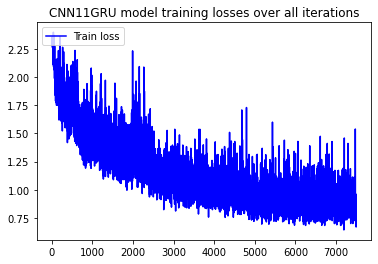

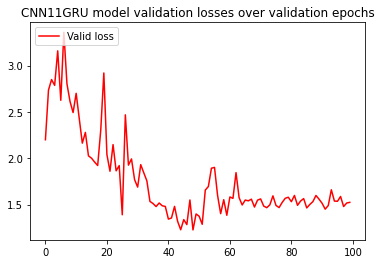

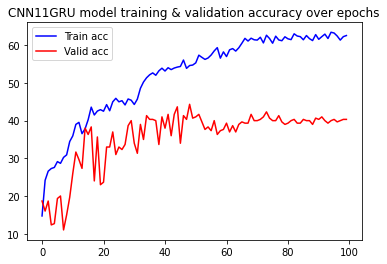

In [205]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("CNN11GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("CNN11GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("CNN11GRU model training & validation accuracy over epochs")
plt.show()

In [206]:
CNN11GRU_test_acc_result, y_pred, y_true = test(model_CNN11GRU, n_layers=11)
print(CNN11GRU_test_acc_result)


Test set accuracy: 111/300 (37%)

37.0


Normalized confusion matrix


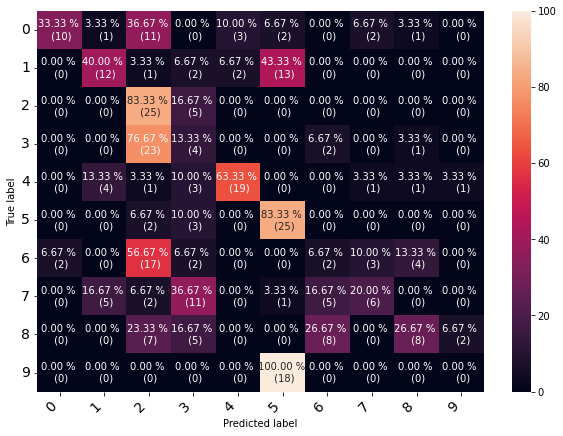

In [207]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## CNN18GRU Train

In [208]:
#CNN18GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_CNN18GRU.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_CNN18GRU, epoch, log_interval, n_layers=18)
        validate(model_CNN18GRU, epoch, n_layers=18)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.307777	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.284413	Accuracy: 73/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.225189	Accuracy: 171/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.161591	Accuracy: 300/2400 (12%)

Validation Epoch: 1 	Loss: 2.315886	Accuracy: 49/300 (16%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 2.070772	Accuracy: 10/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.057736	Accuracy: 177/2400 (7%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 2.076111	Accuracy: 341/2400 (14%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.869694	Accuracy: 516/2400 (22%)

Validation Epoch: 2 	Loss: 1.944129	Accuracy: 56/300 (19%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 1.732378	Accuracy: 14/2400 (1%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 2.043818	Accuracy: 216/2400 (9%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.750718	Accuracy: 410/2400 (17%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.599357	Accuracy: 648/2400 (27%)

Validation Epoch: 3 	Loss: 1

Train Epoch: 24 [1280/2400 (53%)]	Loss: 0.586719	Accuracy: 1147/2400 (48%)
Train Epoch: 24 [1920/2400 (80%)]	Loss: 0.510156	Accuracy: 1706/2400 (71%)

Validation Epoch: 24 	Loss: 1.370239	Accuracy: 164/300 (55%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 0.520698	Accuracy: 27/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 0.550937	Accuracy: 580/2400 (24%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 0.333376	Accuracy: 1150/2400 (48%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 0.342165	Accuracy: 1700/2400 (71%)

Validation Epoch: 25 	Loss: 0.984320	Accuracy: 251/300 (84%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 0.229971	Accuracy: 30/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 0.334959	Accuracy: 604/2400 (25%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 0.394489	Accuracy: 1176/2400 (49%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 0.499162	Accuracy: 1754/2400 (73%)

Validation Epoch: 26 	Loss: 0.534912	Accuracy: 244/300 (81%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 0.412955	Accuracy: 28/2400 (1%)
Train Epoch

Train Epoch: 47 [1920/2400 (80%)]	Loss: 0.053403	Accuracy: 1904/2400 (79%)

Validation Epoch: 47 	Loss: 0.385407	Accuracy: 275/300 (92%)

Train Epoch: 48 [0/2400 (0%)]	Loss: 0.071612	Accuracy: 32/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 0.069999	Accuracy: 648/2400 (27%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.063159	Accuracy: 1272/2400 (53%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.054162	Accuracy: 1899/2400 (79%)

Validation Epoch: 48 	Loss: 0.374059	Accuracy: 276/300 (92%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.058693	Accuracy: 32/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.074283	Accuracy: 661/2400 (28%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.262508	Accuracy: 1288/2400 (54%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.049347	Accuracy: 1918/2400 (80%)

Validation Epoch: 49 	Loss: 0.160195	Accuracy: 277/300 (92%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.077206	Accuracy: 31/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.109376	Accuracy: 654/2400 (27%)
Train Epoch: 


Validation Epoch: 70 	Loss: 0.308031	Accuracy: 276/300 (92%)

Train Epoch: 71 [0/2400 (0%)]	Loss: 0.050612	Accuracy: 32/2400 (1%)
Train Epoch: 71 [640/2400 (27%)]	Loss: 0.086963	Accuracy: 666/2400 (28%)
Train Epoch: 71 [1280/2400 (53%)]	Loss: 0.100587	Accuracy: 1289/2400 (54%)
Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.058096	Accuracy: 1925/2400 (80%)

Validation Epoch: 71 	Loss: 0.313255	Accuracy: 275/300 (92%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.060876	Accuracy: 32/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.031998	Accuracy: 666/2400 (28%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.038188	Accuracy: 1300/2400 (54%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.042654	Accuracy: 1930/2400 (80%)

Validation Epoch: 72 	Loss: 0.345948	Accuracy: 275/300 (92%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.128030	Accuracy: 31/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.083742	Accuracy: 665/2400 (28%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.044856	Accuracy: 1302/2400 (54%)
Train Epoch: 

Train Epoch: 94 [640/2400 (27%)]	Loss: 0.039105	Accuracy: 664/2400 (28%)
Train Epoch: 94 [1280/2400 (53%)]	Loss: 0.040145	Accuracy: 1300/2400 (54%)
Train Epoch: 94 [1920/2400 (80%)]	Loss: 0.088057	Accuracy: 1934/2400 (81%)

Validation Epoch: 94 	Loss: 0.316308	Accuracy: 276/300 (92%)

Train Epoch: 95 [0/2400 (0%)]	Loss: 0.055802	Accuracy: 32/2400 (1%)
Train Epoch: 95 [640/2400 (27%)]	Loss: 0.039132	Accuracy: 664/2400 (28%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.052421	Accuracy: 1298/2400 (54%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.034058	Accuracy: 1931/2400 (80%)

Validation Epoch: 95 	Loss: 0.301474	Accuracy: 276/300 (92%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.092418	Accuracy: 32/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.041931	Accuracy: 669/2400 (28%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.051864	Accuracy: 1299/2400 (54%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.037894	Accuracy: 1934/2400 (81%)

Validation Epoch: 96 	Loss: 0.221031	Accuracy: 275/300 (92%)

Train 

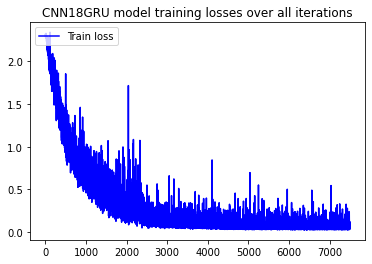

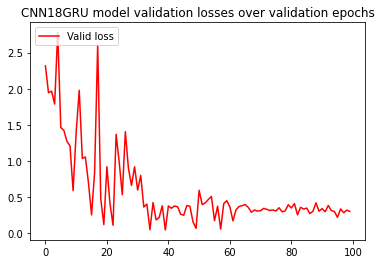

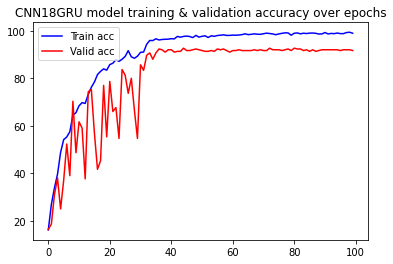

In [209]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("CNN18GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("CNN18GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("CNN18GRU model training & validation accuracy over epochs")
plt.show()

In [210]:
CNN18GRU_test_acc_result, y_pred, y_true = test(model_CNN18GRU, n_layers=18)
print(CNN18GRU_test_acc_result)


Test set accuracy: 269/300 (90%)

89.66666666666667


Normalized confusion matrix


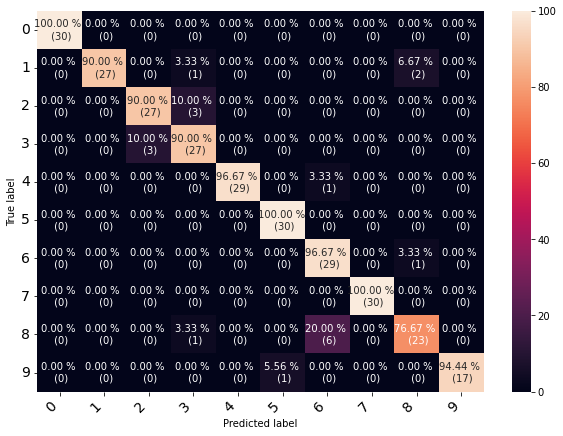

In [211]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

In [212]:
print('Number of epochs:', epoch_count)
print(f"\nCNN3GRU model accuracy: {(CNN3GRU_test_acc_result):.0f}%")
print(f"CNN5GRU model accuracy: {(CNN5GRU_test_acc_result):.0f}%")
print(f"CNN11GRU model accuracy: {(CNN11GRU_test_acc_result):.0f}%")
print(f"CNN18GRU model accuracy: {(CNN18GRU_test_acc_result):.0f}%")

Number of epochs: 100

CNN3GRU model accuracy: 60%
CNN5GRU model accuracy: 65%
CNN11GRU model accuracy: 37%
CNN18GRU model accuracy: 90%
